In [1]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from bltk.langtools import Tokenizer, remove_stopwords
from bangla_stemmer.stemmer import stemmer

In [2]:
raw_train_data = pd.read_excel('train.xlsx', index_col = 0) 
raw_val_data = pd.read_excel('val.xlsx', index_col = 0)
raw_test_data = pd.read_excel('test.xlsx', index_col = 0)
print(raw_train_data.shape)
print(raw_test_data.shape)
print(raw_val_data.shape)

(4994, 3)
(625, 3)
(624, 3)


In [3]:
#The Bengali Characters

from bltk.langtools.banglachars import (vowels,
                                        vowel_signs,
                                        consonants,
                                        digits,
                                        operators,
                                        punctuations,
                                        others)
print(f'Vowels: {vowels}')
print(f'Vowel signs: {vowel_signs}')
print(f'Consonants: {consonants}')
print(f'Digits: {digits}')
print(f'Operators: {operators}')
print(f'Punctuation marks: {punctuations}')
print(f'Others: {others}')

Vowels: ['অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'ঌ', 'এ', 'ঐ', 'ও', 'ঔ']
Vowel signs: ['া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ৄ', 'ে', 'ৈ', 'ো', 'ৌ']
Consonants: ['ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ']
Digits: ['০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯']
Operators: ['=', '+', '-', '*', '/', '%', '<', '>', '×', '÷']
Punctuation marks: ['।', ',', ';', ':', '?', '!', "'", '.', '"', '-', '[', ']', '{', '}', '(', ')', '–', '—', '―', '~']
Others: ['৳', '৺', '্', 'ঀ', 'ঽ', '#', '$']


In [4]:
def preprocess_bangla_text(text):
    
    #Tokenize the text
    tokenizer = Tokenizer()
    words = tokenizer.word_tokenizer(text)
    
    #Remove Stopword
    filtered_words = remove_stopwords(words)
    
    #Stem Words:
    stmer = stemmer.BanglaStemmer()
    stemmed_words = [stmer.stem(word) for word in filtered_words]
    stemmed_text = " ".join(stemmed_words)
    
    #remove HTML tag from the text
    html_tag = re.compile(r'<.*?>')
    html_clean_text = re.sub(html_tag,'',stemmed_text)
    
    #remove url
    url_clean = re.compile(r"https://\S+|www\.\S+")
    url_clean_text = re.sub(url_clean,'',html_clean_text)
    
    #remove emojies
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U0001FAE0-\U0001FAFF"  # Symbols for Legacy Computing
                           u"\U0001FAC0-\U0001FAFF"  # Additional emoticons
                           u"\U0001F004-\U0001F0CF"  # Miscellaneous Symbols and Pictographs
                           u"\U0001F170-\U0001F251"  # Enclosed Alphanumeric Supplement
                           "]+", flags=re.UNICODE)
    emoji_clean_text = re.sub(emoji_pattern,'',url_clean_text)
    
    preprocessed_text = emoji_clean_text
    return preprocessed_text
    


In [5]:
raw_train_data['clean_text'] = raw_train_data['text'].apply(preprocess_bangla_text)
raw_test_data['clean_text'] = raw_test_data['text'].apply(preprocess_bangla_text)
raw_val_data['clean_text'] = raw_val_data['text'].apply(preprocess_bangla_text)

applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fo

applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
appli

applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fo

applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
app

applied third rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied third rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
app

applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules

applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
appli

applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fir

applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied

applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied 

applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applie

applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
appl

applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applie

applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
appl

applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied third rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
appl

applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
app

applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
appl

applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied

applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..


applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied

applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied third rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..


applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied third rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied

applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied third rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied second rules..
ap

applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied third rules..
applied first rules..
applied fourth rules..
applied f

applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied third rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
ap

applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..


applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applie

applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied

applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
appli

applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied f

applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
appli

applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied

applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied f

applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied third rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..


applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied third rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied f

applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied third rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied

applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
appl

applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied

applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied seco

applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied f

applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied third rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applie

applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applie

applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied second rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied second rules..
applied fourth rules..
applied fourth rules..
app

applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied 

applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applie

applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
app

applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied s

applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applie

applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applie

applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fi

applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied third rules..
applied fourth rules..
appl

applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied

applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied third rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
appli

applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fou

applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fo

applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
appl

In [6]:
merged_df = pd.concat([raw_train_data, raw_test_data, raw_val_data], axis=0)

In [7]:
merged_df.shape

(6243, 4)

In [8]:
merged_df.head()

,text,classes,labels,clean_text
0,মেডিকেলে এসে ঠিক ফ্যামিলির ফটো ফ্রেম এর মতো মন...,sadness,1,মেডিকেল এসে ফ্যামিলির ফটো ফ্রেম মত মনে হত নিজে...
1,অনেক দিন পর অন্য রকম অনুভূতি হচ্ছে কেননা আমার...,sadness,1,অনেক দিন পর অন্য রকম অনুভূতি কেননা সদ্য পাশ কর...
2,আগে যতোটা বেশি পছন্দ করতাম দুশ্চরিত্রা মিথিলা ...,disgust,3,যতো বেশি পছন্দ করতাম দুশ্চরিত্ মিথিলা মুখার্জি...
3,মাঝে মাঝে মনে হয় তোমাকে চাওয়াটা অনেক ভুল হয়ত ভ...,sadness,1,মনে তোমাকে চাওয়া অনেক ভুল হয়ত ভুল তবে ভুল মাশু...
4,এখানে কাওকে কবর দিয়ো না তাহলে তোমাদের পরিবারের...,fear,5,কাওকে কবর দিয়ো তোমা পরিবার আর কেউ বেঁচে থাকবে ...


In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical

In [43]:
class_distribution = merged_df["classes"].value_counts()


<Axes: >

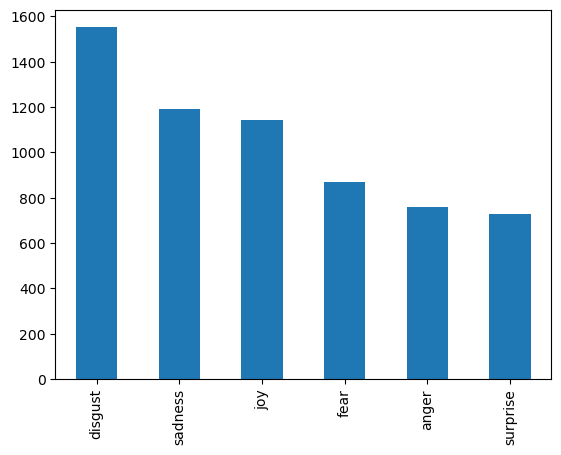

In [45]:
class_distribution.plot(kind='bar')

In [46]:
!pip install -U imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   ---------------------------------------  235.5/235.6 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  235.5/235.6 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  235.5/235.6 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  235.5/235.6 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  235.5/235.6 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  235.5/235.6 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  235.5/235.6 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  235.5/235.6 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------  235.5/235.6 kB 4.8 MB/s eta

In [35]:
X = merged_df["clean_text"]
y = merged_df["classes"]

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# TF-IDF Vectorization with n-grams
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # Adjust ngram_range and features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert sparse matrices to dense NumPy arrays
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

# Reshape the TF-IDF vectors for input to the CNN
X_train_tfidf = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_tfidf = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

In [55]:
X_train_tfidf.shape

(4994, 1000, 1)

In [ ]:
X_train_tfidf = X_train_tfidf.reshape(X_train_tfidf.shape[0],-1)

In [58]:
from imblearn.over_sampling import SVMSMOTE

svmsmote = SVMSMOTE(sampling_strategy='auto', random_state=42)
X_train_tfidf, y_train = svmsmote.fit_resample(X_train_tfidf, y_train)

In [62]:
X_train_tfidf.shape

(6895, 1000)

In [59]:
# Build a simple CNN model for text classification
model = Sequential()
model.add(Conv1D(64, 5, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [60]:
batch_size = 64
epochs = 50
model.fit(X_train_tfidf, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/50
108/108 [==============================] - 7s 57ms/step - loss: 1.4608 - accuracy: 0.4292
Epoch 2/50
108/108 [==============================] - 6s 59ms/step - loss: 1.2000 - accuracy: 0.5459
Epoch 3/50
108/108 [==============================] - 6s 56ms/step - loss: 1.0947 - accuracy: 0.5974
Epoch 4/50
108/108 [==============================] - 6s 58ms/step - loss: 1.0073 - accuracy: 0.6326
Epoch 5/50
108/108 [==============================] - 6s 60ms/step - loss: 0.9193 - accuracy: 0.6751
Epoch 6/50
108/108 [==============================] - 7s 60ms/step - loss: 0.8263 - accuracy: 0.7143
Epoch 7/50
108/108 [==============================] - 6s 59ms/step - loss: 0.7250 - accuracy: 0.7565
Epoch 8/50
108/108 [==============================] - 6s 58ms/step - loss: 0.6229 - accuracy: 0.7984
Epoch 9/50
108/108 [==============================] - 6s 60ms/step - loss: 0.5260 - accuracy: 0.8334
Epoch 10/50
108/108 [==============================] - 6s 60ms/step - loss: 0.4290 - accura

In [61]:
oss, accuracy = model.evaluate(X_test_tfidf, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

40/40 [==============================] - 1s 11ms/step - loss: 3.6241 - accuracy: 0.5044
Test Accuracy: 50.44%
